In [1]:
import sys
sys.path.append('/usr/local/lib')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.colors as mcol
import matplotlib.cm as cm
import math
import time
import pandas as pd
import json
import pyrealsense2 as rs
import cv2
from scipy import stats
from itertools import cycle
cycol = cycle('bgrcmk') #here I'm generating a list of colors I can plot

In [3]:
# Enabling Advanced Mode

DS5_product_ids = ["0AD1", "0AD2", "0AD3", "0AD4", "0AD5", "0AF6", "0AFE", "0AFF", "0B00", "0B01", "0B03", "0B07"]

def find_device_that_supports_advanced_mode() :
    ctx = rs.context()
    ds5_dev = rs.device()
    devices = ctx.query_devices();
    for dev in devices:
        if dev.supports(rs.camera_info.product_id) and str(dev.get_info(rs.camera_info.product_id)) in DS5_product_ids:
            if dev.supports(rs.camera_info.name):
                print("Found device that supports advanced mode:", dev.get_info(rs.camera_info.name))
            return dev
    raise Exception("No device that supports advanced mode was found")

try:
    dev = find_device_that_supports_advanced_mode()
    advnc_mode = rs.rs400_advanced_mode(dev)
    print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    # Loop until we successfully enable advanced mode
    while not advnc_mode.is_enabled():
        print("Trying to enable advanced mode...")
        advnc_mode.toggle_advanced_mode(True)
        # At this point the device will disconnect and re-connect.
        print("Sleeping for 5 seconds...")
        time.sleep(5)
        # The 'dev' object will become invalid and we need to initialize it again
        dev = find_device_that_supports_advanced_mode()
        advnc_mode = rs.rs400_advanced_mode(dev)
        print("Advanced mode is", "enabled" if advnc_mode.is_enabled() else "disabled")

    
except Exception as e:
    print(e)
pass

Found device that supports advanced mode: Intel RealSense D415
Advanced mode is enabled


In [4]:
# Loading presaved parameters 
# If I have another set of parameters I'd like to use already in the json format, I can skip the previous three blocks of code
    
with open("canonical-params.json") as json_data: #Json file to be loaded #NOTE im using default NOT the json that I just created above
    starting_params = json.load(json_data)
    starting_params=str(starting_params).replace("'", '\"') #IF YOU DON't DO THIS IT WILL NOT WORK with the librealsense sdk
    print(starting_params)

{"param-disableraucolor": "0", "param-disablesadcolor": "0", "param-disablesadnormalize": "0", "param-disablesloleftcolor": "0", "param-disableslorightcolor": "0", "param-lambdaad": "800", "param-lambdacensus": "26", "param-leftrightthreshold": "50", "param-maxscorethreshb": "2610", "param-medianthreshold": "500", "param-minscorethresha": "1", "param-neighborthresh": "7", "param-robbinsmonrodecrement": "10", "param-robbinsmonroincrement": "10", "param-secondpeakdelta": "325", "param-texturecountthresh": "0", "param-texturedifferencethresh": "0", "param-raumine": "1", "param-rauminn": "1", "param-rauminnssum": "3", "param-raumins": "1", "param-rauminw": "1", "param-rauminwesum": "3", "param-regionshrinku": "3", "param-regionshrinkv": "1", "param-regioncolorthresholdr": "0.05", "param-regioncolorthresholdg": "0.05", "param-regioncolorthresholdb": "0.05", "param-rsmdiffthreshold": "4", "param-rsmrauslodiffthreshold": "1", "param-rsmremovethreshold": "0.375", "param-usersm": "1", "param-sc

In [5]:
#Experimental Loop

frame_width=640
frame_height=480
fps=90
number_of_frames_to_record=10000
file = open('pythondepthdata.bin', 'a+b') #open a file for apending binary data
# Configure depth and color streams
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, frame_width, frame_height, rs.format.z16, fps)
#config.enable_stream(rs.stream.color, frame_width, frame_height, rs.format.bgr8, fps)
advnc_mode.load_json(starting_params) #this is where I start with the Defualt Json
# Start streaming
cfg = pipeline.start(config)
dev = cfg.get_device()
depth_sensor = dev.first_depth_sensor()
#depth_sensor.set_option(rs.option.visual_preset, 2)


iteration = 0;
#preset = 0;
#preset_name = '';
tick=0; #keeping track of the number of loops the experiment has gone through 
background_chunk=500 #I want to use 500 frames for recording the background

In [6]:
start_of_loop=time.time()
with open('pythondepthdata.bin','ab') as binarydata: #While the file called "pythonedpthdata.bin" is open for appending binary, 
    try:
        while tick<number_of_frames_to_record: #aiming for 2000 frames
            tick=tick+1 
            
            # Wait for a coherent pair of frames: depth and color
            frames = pipeline.wait_for_frames()
            depth_frame = frames.get_depth_frame()
            #color_frame = frames.get_color_frame()
        
            #iteration = iteration + 1
            #if iteration > 100:
               #preset = preset + 1
               #iteration = 0
               #range = depth_sensor.get_option_range(rs.option.visual_preset)
               #preset = preset % range.max
               #depth_sensor.set_option(rs.option.visual_preset, preset)
               #preset_name = depth_sensor.get_option_value_description(rs.option.visual_preset, preset)
        
            # Convert images to numpy arrays
            depth_image = np.asanyarray(depth_frame.get_data())
            #color_image = np.asanyarray(color_frame.get_data())
            depth_image.tofile(binarydata) #save data as binarydata (specified by the with open as line)
            
            #if tick==background_chunk:
                #output=input("please insert calibration object  ")
        
            # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
            #depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, None, 0.5, 0), cv2.COLORMAP_JET)

            # Stack both images horizontally
            #images = np.hstack((color_image, depth_colormap))
        
            #font = cv2.FONT_HERSHEY_SIMPLEX
            #cv2.putText(images, preset_name,(60,80), font, 4,(255,255,255),2,cv2.LINE_AA) 

            # Show images
            #cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
            #cv2.imshow('RealSense', images)
            #cv2.waitKey(1)
            with open('depth_ts.txt', 'a') as ts:
                ts.write('%s\n' %rs.frame.get_timestamp(frames)) #write time stamp float as a string to a new line

    finally:

        # Stop streaming
        pipeline.stop()
        end_of_loop=time.time() #end timer
        print("Time Elapsed = ", end_of_loop - start_of_loop)
        serialized_string = advnc_mode.serialize_json() #getting the current parameters as a serialized string
        as_json_object = json.loads(serialized_string) #loading the json object from the serialized string
        json_used_in_experiment = str(as_json_object).replace("'", '\"') #converting object into string that can be printed
        print("Final Parameters = ", json_used_in_experiment)

Time Elapsed =  118.36107850074768
Final Parameters =  {"aux-param-autoexposure-setpoint": "400", "aux-param-colorcorrection1": "0.461914", "aux-param-colorcorrection10": "-0.553711", "aux-param-colorcorrection11": "-0.553711", "aux-param-colorcorrection12": "0.0458984", "aux-param-colorcorrection2": "0.540039", "aux-param-colorcorrection3": "0.540039", "aux-param-colorcorrection4": "0.208008", "aux-param-colorcorrection5": "-0.332031", "aux-param-colorcorrection6": "-0.212891", "aux-param-colorcorrection7": "-0.212891", "aux-param-colorcorrection8": "0.68457", "aux-param-colorcorrection9": "0.930664", "aux-param-depthclampmax": "65536", "aux-param-depthclampmin": "0", "aux-param-disparityshift": "14", "controls-autoexposure-auto": "True", "controls-autoexposure-manual": "33000", "controls-color-autoexposure-auto": "True", "controls-color-autoexposure-manual": "166", "controls-color-backlight-compensation": "0", "controls-color-brightness": "0", "controls-color-contrast": "50", "contro

In [7]:
#delete all variables
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [8]:
frame_width=640
frame_height=480
fps=90
number_of_frames_to_record=2000
background_chunk=500

In [9]:
#redo the imports
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.colors as mcol
import matplotlib.cm as cm
import math
import time
import pandas as pd
import json
import pyrealsense2 as rs
import cv2
from scipy import stats
from itertools import cycle
cycol = cycle('bgrcmk') #here I'm generating a list of colors I can plot

In [10]:
rawframes = np.fromfile('pythondepthdata.bin', dtype=np.uint16) #A highly efficient way of reading binary data with a known data-type, as well as parsing simply formatted text files. Data written using the tofile method can be read using this function.
frames = rawframes.reshape(-1, frame_height, frame_width) #.reshape simply restructures data into dimensions of your choosing. -1 means find the number of segments that structures the data into the dimnesions shown afterwards

In [20]:
del rawframes

In [11]:
number_of_frames,video_height,video_width=frames.shape[0],frames.shape[1],frames.shape[2];
#set number of frames equal to the first element in reshaped.shape
#set video height to the second element in reshaped.shape
#set video width to the third element in reshaped.shape
print('The shape of the video is {0} by {1} and it has {2} frames'.format(video_height,video_width,number_of_frames))
#note that the nubmers below are one greater than the actual indices that exist
#there is no reshaped[number_of_frames,height,width], the last frame is reshaped[number_of_frames-1,height-1,width-1]

The shape of the video is 480 by 640 and it has 10000 frames


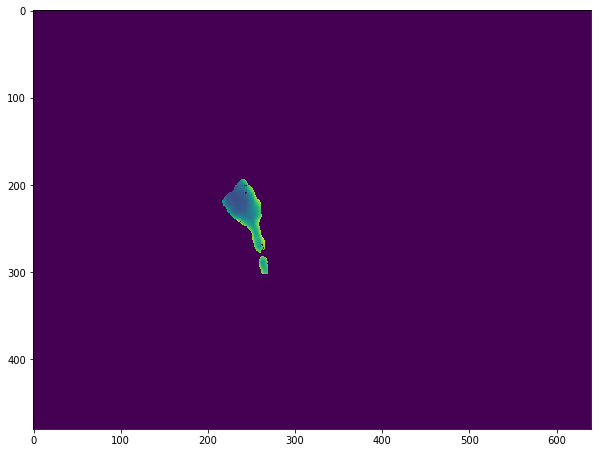

In [12]:
#Now let's try to put this all together but in another random frame
#pick a frame
picked_frame=1500
frame_of_interest=frames[picked_frame] 
#know your background (I happen to know background is between frame 5250 and 5350)
backgroundmean=np.mean(frames[0:background_chunk], axis=0) #may be better to use median
backgroundvariance=np.var(frames[0:background_chunk], axis=0)
#if the difference between the background and the frame is greater than expected, it's probably our object! 
#note that I arbitrarily pick 5 stdeviations away, it's worth knowing if the noise is actually gaussian
backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (9*np.sqrt(backgroundvariance)) #if its 5 standard its NOISE
#we expect positive values for high differences. make them stay by multiplying by 1
backgroundmultiplier[backgroundmultiplier>0]=1
#we expect negative values or no change for small differences. probably just noise, get rid of them by multiplying by 0
backgroundmultiplier[backgroundmultiplier<=0]=0
#apply our expectations to the matrix
frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest,backgroundmultiplier)

#I can plot the background subtracted image
fig=plt.figure(figsize=(10,10))
plt.imshow(frame_of_interest_backgroundsubtracted)
object_median=np.median(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted>0])
plt.clim(object_median-100,object_median+100)
#fig.savefig('calibration_object.png')

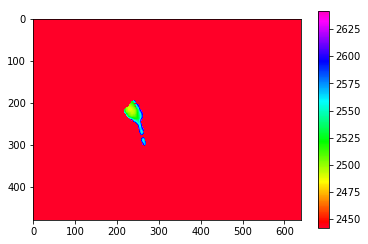

In [13]:
plt.colorbar(plt.imshow(frame_of_interest_backgroundsubtracted,cmap='gist_rainbow'))
plt.clim(object_median-100,object_median+100)

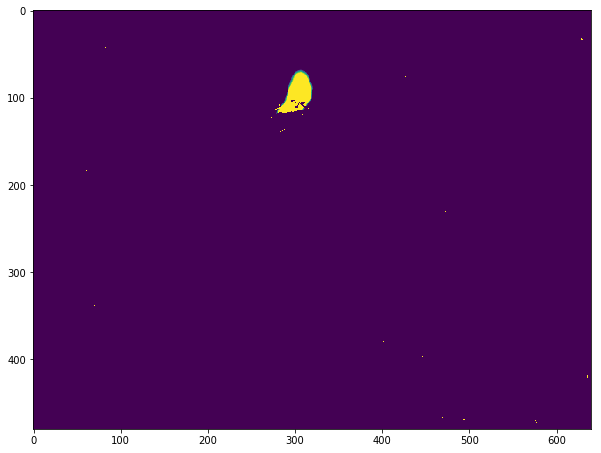

In [14]:
#Now let's try to put this all together but in another random frame
#pick a frame
picked_frame=950
frame_of_interest=frames[picked_frame]
#know your background (I happen to know background is between frame 5250 and 5350)
backgroundmean=np.mean(frames[0:background_chunk], axis=0)
backgroundvariance=np.var(frames[0:background_chunk], axis=0)
#if the difference between the background and the frame is greater than expected, it's probably our object! 
#note that I arbitrarily pick 5 stdeviations away, it's worth knowing if the noise is actually gaussian
backgroundmultiplier=np.abs(frame_of_interest - backgroundmean) - (10*np.sqrt(backgroundvariance)) #if its 5 standard its NOISE
#we expect positive values for high differences. make them stay by multiplying by 1
backgroundmultiplier[backgroundmultiplier>0]=1
#we expect negative values or no change for small differences. probably just noise, get rid of them by multiplying by 0
backgroundmultiplier[backgroundmultiplier<=0]=0
#apply our expectations to the matrix

frame_of_interest_backgroundsubtracted=np.multiply(np.subtract(frame_of_interest,backgroundmean),-1) #subtract the background mean and then multiply result by negative 1 since the camera counts distance away 
frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest_backgroundsubtracted,backgroundmultiplier) #pixels that arent significantly different are considered background 
frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted<0]=0 #everything less than 0 IS zero
frame_of_interest_backgroundsubtracted=np.multiply(frame_of_interest_backgroundsubtracted,10) #go from cm to mm
frame_of_interest_backgroundsubtracted=np.rint(frame_of_interest_backgroundsubtracted) #make everything an integer


#Plotting background-subtracted image
plt.figure(figsize=(10,10)) #can set this equal to fig
plt.imshow(frame_of_interest_backgroundsubtracted)
object_median=np.median(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted>0])
plt.clim(object_median-100,object_median+100)
#fig.savefig('title_of_fig.png')

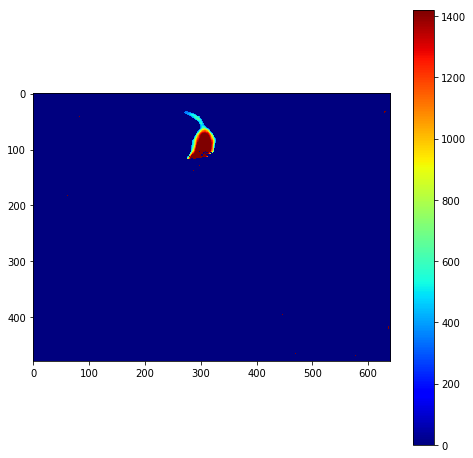

In [21]:
plt.figure(figsize=(8,8)) #can set this equal to fig
plt.colorbar(plt.imshow(frame_of_interest_backgroundsubtracted,cmap='jet'))
plt.clim(0,object_median+100)
#fig.savefig('tile of figure')

In [16]:
#The two objects I used in this examples were two stack of manilla folders. One stacks was 40 folders, the other was 20 folders. I measured the heights to be 2.69875 and 1.42875 cm respectively

In [17]:
#getting a list of pixel value and frequencies
#np.set_printoptions(threshold=np.nan) # see the entire np array
#unique,counts=np.unique(frame_of_interest_backgroundsubtracted,return_counts=True)
#print(np.asarray((unique,counts)).T)

In [18]:
#objectmean=np.mean(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0])
#objectvariance=np.var(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0])
#objectsigma=np.sqrt(objectvariance)
#print(objectmean)

1594.70928196


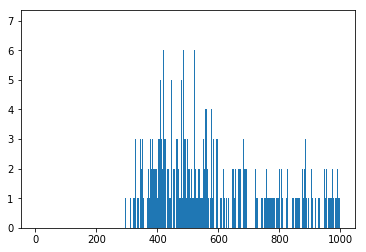

In [19]:
plt.hist(frame_of_interest_backgroundsubtracted[frame_of_interest_backgroundsubtracted != 0],bins=range(1,1000))
plt.show()